In [2956]:
import numpy as np
import os
import copy
import pickle
import heapq
import matplotlib.pyplot as plt

Const

In [2961]:
hyperparameter = [1, 1]
""" distanceThresholdCoeff: dynamicThreshold = hyperparameter[0] * self.lastMoveSuccessRateByHold() """

' distanceThresholdCoeff: dynamicThreshold = hyperparameter[0] * self.lastMoveSuccessRateByHold() '

In [2962]:
cwd = os.getcwd()
parent_wd = cwd.replace('/preprocessing', '')
raw_data_path = parent_wd + '/MoonBoardRNN/preprocessing/processed_data_deltaxy_mode'  
url_data_path = parent_wd + '/MoonBoardRNN/raw_data/moonGen_scrape_2016_cp'

In [2963]:
with open(url_data_path, 'rb') as f:
    MoonBoard_2016_withurl = pickle.load(f)

In [2964]:
####################
# Input hold information & load moonboard problem
####################
#raw_data_path1 = "MoonBoardRNN/raw_data/moonGen_scrape_2016_cp"  ### raw Data
#raw_data_path = "MoonBoardRNN/raw_data/processed_data_xy_mode"
with open(raw_data_path, 'rb') as f:
    MoonBoard_2016_raw = pickle.load(f)
"""
    Input:
    - xy_mode_processed_data: 
      if set False(default), the x_vector compiled will be of shape (10, n_holds) (6 hold features, x, y, is_start, is_end)
      if set True, the x_vector compiled will be of shape (14, n_holds) (6 hold features, x, y, dx1, dy1, dx2, dy2, is_start, is_end)
    
    Classify and process the raw data into 4 caterogies/8 dictionaries:
    - X_dict_benchmark_withgrade: the input data that is benchmarked and contains user grading.
    - Y_dict_benchmark_withgrade: the output for raw data that is benchmarked and contains user grading.
    - X_dict_benchmark_nograde: the input data that is benchmarked and does not contain user grading.
    - Y_dict_benchmark_nograde: the output for raw data that is benchmarked and does not contain user grading.
    - X_dict_withgrade: the input data that is not benchmarked and contains user grading.
    - Y_dict_withgrade: the output for raw data that is not benchmarked and contains user grading.
    - X_dict_nograde: the input data that is not benchmarked and does not contain user grading.
    - Y_dict_nograde: the output for raw data that is not benchmarked and does not contain user grading.
    For the ones that do not have user grading, the shape of each item in Y_dict is (2, 1): (grade, is_benchmarked)
    For the ones that have user grading, the shape of each item in Y_dict is (3, 1): (grade, is_benchmarked, user_grade)
"""    

'\n    Input:\n    - xy_mode_processed_data: \n      if set False(default), the x_vector compiled will be of shape (10, n_holds) (6 hold features, x, y, is_start, is_end)\n      if set True, the x_vector compiled will be of shape (14, n_holds) (6 hold features, x, y, dx1, dy1, dx2, dy2, is_start, is_end)\n    \n    Classify and process the raw data into 4 caterogies/8 dictionaries:\n    - X_dict_benchmark_withgrade: the input data that is benchmarked and contains user grading.\n    - Y_dict_benchmark_withgrade: the output for raw data that is benchmarked and contains user grading.\n    - X_dict_benchmark_nograde: the input data that is benchmarked and does not contain user grading.\n    - Y_dict_benchmark_nograde: the output for raw data that is benchmarked and does not contain user grading.\n    - X_dict_withgrade: the input data that is not benchmarked and contains user grading.\n    - Y_dict_withgrade: the output for raw data that is not benchmarked and contains user grading.\n    -

In [2965]:
(MoonBoard_2016_raw["X_dict_benchmark_withgrade"]).keys()

dict_keys(['337509', '332721', '332646', '325637', '325079', '324257', '322941', '322939', '321511', '321097', '320798', '320394', '314508', '311645', '310143', '310106', '309814', '308058', '307834', '306777', '306776', '306062', '305694', '305656', '300214', '297887', '292263', '281994', '279557', '274947', '273016', '260849', '256493', '254625', '251124', '251082', '249317', '243461', '241018', '234401', '232300', '229614', '227999', '226072', '214484', '213011', '202064', '201921', '201020', '199740', '199290', '196769', '196284', '192888', '192428', '192386', '191609', '190906', '189969', '189344', '184714', '184462', '184295', '181440', '181435', '179415', '178758', '176870', '176230', '174899', '172010', '171918', '171796', '171787', '171108', '170230', '170190', '170185', '169636', '166287', '164879', '164874', '160922', '160167', '159366', '158675', '158100', '156084', '152217', '150763', '150053', '149984', '144021', '142730', '141821', '139394', '137897', '137242', '136668',

In [2966]:
keyNum = "310143"    
#moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])["102018"]
#moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])["337509"]
#moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])["332721"]
moonboardTest = (MoonBoard_2016_raw["X_dict_benchmark_withgrade"])[keyNum]


In [2967]:
class beta:
    """ climbing beta is the climber's feeling of the best hand sequence
    class beta describe how the climber create the beta. It stored information including
    moonboard holds information.
    the ongoing built hand sequence (LRLRLRRR) and the hold climber used
    """
    def __init__(self, avalible_holds):
        """Creates a new beta with the specified attributes."""
        self.totalNumOfHold = np.size(avalible_holds, axis=0)
        self.allHolds = avalible_holds
        self.handSequence = []        # Use the number 0,1,2,3,4,5... sequence
        self.handOperator = [] # op: Right hand / Left Hand
        self.holdsNotUsed = []           # You can then use this list to decide where to go next
        self.holdsNotUsed.extend(range(self.totalNumOfHold))
        self.isFinished = False          # True when go to finish hold (neglect matching)
        self.overallSuccess = 1      # Can evaluate difficulty of this beta
        self.singleMoveSuccessRate = []  # singleMoveDifficulty
        self.tryout = 0                  # Try one additional point. Record successRate
        self.touchEndHold = 0
    
    def addStartHolds(self, zeroOrOne):
        opList = ["LH", "RH"]
        startHoldList = self.getStartHold()
        if len(startHoldList) == 1:
            self.handSequence.append(int(self.getOrderFromHold(startHoldList[0])))   # Add a new hold into beta!
            self.handSequence.append(int(self.getOrderFromHold(startHoldList[0])))
            self.handOperator.extend(opList) 
            self.holdsNotUsed.remove(self.getOrderFromHold(startHoldList[0]))   # Not consider match
        if len(startHoldList) == 2:  
            self.handSequence.append(int(self.getOrderFromHold(startHoldList[0])))   # Add a new hold into beta!
            self.handSequence.append(int(self.getOrderFromHold(startHoldList[1])))
            self.handOperator.append(opList[zeroOrOne]) 
            self.handOperator.append(opList[1-zeroOrOne]) # indicate which hand
            self.holdsNotUsed.remove(self.getOrderFromHold(startHoldList[0]))   # Not consider match
            self.holdsNotUsed.remove(self.getOrderFromHold(startHoldList[1]))
            
    def getAllHolds(self):
        """N holds rows, 10 columns np array"""
        return self.allHolds
    
    def tryMove(self, tryOrder, op):
        """Try how addition hold. Return successRate, tryOrder is a number in holdsNotUsed 
           list. op is either "LH" or "RH" """
        tryHold = self.allHolds[tryOrder]
        finalXY = self.getXYFromOrder(tryOrder)    
        if op == "LH":
            originalXY = self.getXYFromOrder(self.getrightHandOrder())
            dontCross = 1  # Penalty of do a big cross. Larger will drop the successRate
            if originalXY[0] < finalXY[0] - 2.5:
                dontCross = 0#2 * (finalXY[0] - 1.5 - originalXY[0])
                
            print("LHEasy? = ", self.successRateByHold(tryHold, "LH"))
            print("RHEasy? = ", self.successRateByHold(self.getrightHandHold(), "RH"))
            print("distanceOfFinalState = ", self.getTwoOrderDistance(self.getrightHandOrder(), tryOrder))
            return self.successRateByHold(tryHold, "LH") * self.successRateByHold(self.getrightHandHold(), "RH") * dontCross / (self.getTwoOrderDistance(self.getrightHandOrder(), tryOrder))**0.5
            
        elif op == "RH":
            originalXY = self.getXYFromOrder(self.getleftHandOrder())
            dontCross = 1
            if  finalXY[0] < originalXY[0] - 2.5:
                dontCross = 0#2 * (originalXY[0] - 1.5 - finalXY[0])
                
            print("RHEasy? = ", self.successRateByHold(tryHold, "RH"))
            print("LHEasy? = ", self.successRateByHold(self.getleftHandHold(), "LH"))
            print("distanceOfFinalState = ", self.getTwoOrderDistance(self.getleftHandOrder(), tryOrder))
            return self.successRateByHold(tryHold, "RH") * self.successRateByHold(self.getleftHandHold(), "LH") * dontCross / (self.getTwoOrderDistance(self.getleftHandOrder(), tryOrder))**0.5
            

    def addNextHand(self, nextHold, op):
        """ nextHold is a hold, whichHand are  LH, LG, RH, RG"""
        
        if self.touchEndHold == 3: 
            self.handSequence.append(self.totalNumOfHold - 1)  
            if self.handSequence[-1] == "LH":
               self.handOperator.append("RH")  
            if self.handSequence[-1] == "RH":
               self.handOperator.append("LH") 
            self.touchEndHold = self.touchEndHold + 1;
            self.isFinished = True
            #print(self.handSequence, self.handOperator)
        elif self.touchEndHold == 1 or self.isFinished == True: 
            pass
        else:
            if nextHold in self.getEndHoldOrder():
                self.touchEndHold = self.touchEndHold + 1;
                
            # Before Update a new hold
            originalCom = self.getCurrentCom()
            dynamicThreshold = hyperparameter[0] * self.lastMoveSuccessRateByHold()  
 
            # Update a new hold
            self.handSequence.append(nextHold)   # Add a new hold into beta!
            self.handOperator.append(op)         # indicate which hand
            if nextHold not in self.getEndHoldOrder():
                self.holdsNotUsed.remove(nextHold)   # Not consider match
            
            # after add a new hold
            if op == "LH":
                remainingHandOrder = self.getrightHandOrder()
            else:
                remainingHandOrder = self.getleftHandOrder()
            
            finalCom = self.getCom(remainingHandOrder, nextHold)
            distance = np.sqrt(((originalCom[0] - finalCom[0]) ** 2)+((originalCom[1] - finalCom[1]) ** 2))
            


            #newMoveSuccessRate = self.lastMoveSuccessRateByHold() * successRateByDistance(distance, dynamicThreshold)
            #self.singleMoveSuccessRate.append(newMoveSuccessRate)


    def setTrueBeta(self):
        self.isTrueBeta = True   
        
    def getleftHandOrder(self):
        lastIndexOfLeft = ''.join(self.handOperator).rindex('L') / 2
        return self.handSequence[int(lastIndexOfLeft)]
    
    def getrightHandOrder(self):
        """ Output the order of the handSequence"""
        lastIndexOfRight = ''.join(self.handOperator).rindex('R') / 2
        return self.handSequence[int(lastIndexOfRight)]
    
    def getleftHandHold(self):
        return self.allHolds[self.getleftHandOrder()]
    
    def getrightHandHold(self):
        """ Output the order of the handSequence"""
        return self.allHolds[self.getrightHandOrder()]
    
    def getOrderFromHold(self, hold):
        """ from a single hold (np array) to an order"""
        return np.where((self.allHolds == hold).all(1))[0] # Use np.where to get row indices
    
    def getCom(self, hold1Order, hold2Order):
        """ Get the coordinate of COM using current both hands order"""
        xCom = (self.allHolds[hold1Order][6] + self.allHolds[hold2Order][6]) / 2
        yCom = (self.allHolds[hold1Order][7] + self.allHolds[hold2Order][7]) / 2
        return (xCom, yCom)
    
    def getXYFromOrder(self, holdOrder):
        return ((self.allHolds[holdOrder][6]), (self.allHolds[holdOrder][7])) 
        
    def getCurrentCom(self):
        """ Get the coordinate of COM based on current hand position"""
        return self.getCom(self.getleftHandOrder(), self.getrightHandOrder())
    
    def getTwoOrderDistance(self, remainingHandOrder, nextHoldOrder):
        """ Given order 2, and 5. Output distance between"""
        originalCom = self.getCurrentCom()
        finalCom = self.getCom(remainingHandOrder, nextHoldOrder)
        return np.sqrt(((originalCom[0] - finalCom[0]) ** 2)+((originalCom[1] - finalCom[1]) ** 2))

    def orderToSeqOrder(self, order):
        """ Transform from rawdataorder to hand order"""
        return self.handSequence.index(order)
    
    def lastMoveSuccessRateByHold(self):
        operatorLeft = self.handOperator[self.orderToSeqOrder(self.getleftHandOrder())]
        operatorRight = self.handOperator[self.orderToSeqOrder(self.getrightHandOrder())]
        return self.successRateByHold(self.getleftHandHold(), operatorLeft) * self.successRateByHold(self.getrightHandHold(), operatorRight)
    def successRateByHold(self, hold, operation):
        """ """
        if operation == "LH": 
            return max((hold[0] + 2 * hold[1] + hold[2] + hold[5]) **1.2  , (hold[2] / 2 + hold[3] + hold[4])) / hyperparameter[1]
        if operation == "RH":
            return max((hold[2] + 2 * hold[3] + hold[4] + hold[5]) **1.2 , (hold[0] + hold[1] + hold[2] / 2)) / hyperparameter[1]
        
    def getStartHold(self):
        """return startHold list with 2 element"""
        startHoldList = []
        for hold in self.allHolds:
            if hold[8] == 1:
                startHoldList.append(hold)
        return startHoldList

    def getEndHoldOrder(self):
        endHoldOrderList = []
        for hold in self.allHolds:
            if hold[9] == 1:
                endHoldOrderList.append(self.getOrderFromHold(hold))
        if len(endHoldOrderList) == 1:
            endHoldOrderList = [endHoldOrderList[0], endHoldOrderList[0]]
        return endHoldOrderList
    
    def getholdsNotUsed(self):
        return self.holdsNotUsed  
    
    def overallSuccessRate(self):
        numOfHand = len(self.handSequence)
        overallScore = 1;
        for i, order in enumerate(self.handSequence): 
            #print(order)
            #print(self.successRateByHold(self.allHolds[order], self.handOperator[i]))
            overallScore = overallScore * self.successRateByHold(self.allHolds[order], self.handOperator[i])
  
        for i in range (numOfHand - 1):  # Penalty of do a big cross. Larger will drop the successRate   
            targetXY = self.getXYFromOrder(self.handSequence[i+1]) 
            
            #update last L/R hand
            if self.handOperator[i] == "RH":
                lastrightHandXY = self.getXYFromOrder(self.handSequence[i]) 
            if self.handOperator[i] == "LH":    
                lastleftHandXY = self.getXYFromOrder(self.handSequence[i])
                
            if i == 1 and self.handSequence[0] == self.handSequence[1]:  ## not sure
               targetXY = (targetXY[0], targetXY[1] - 1)
            
            if i >= 1 and self.handOperator[i+1] == "RH": #targetXY[0] < originalXY[0] - 2.5 and 
                originalXY = lastleftHandXY
                overallScore = overallScore * makeGaussian(targetXY, 3, (originalXY[0] , originalXY[1]), "LH")
            if i >= 1 and self.handOperator[i+1] == "LH": #originalXY[0] < targetXY[0] - 2.5 and 
                originalXY = lastrightHandXY
                overallScore = overallScore * makeGaussian(targetXY, 3, (originalXY[0], originalXY[1]), "RH")
        self.overallSuccess = overallScore    
        
        
        return overallScore ** (3/numOfHand) 

In [2968]:
def makeGaussian(targetXY, fwhm = 3, center = None, lasthand = "LH"):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = targetXY[0]
    y = targetXY[1]

    x0 = center[0]
    y0 = center[1]
    if lasthand == "RH":
        firstGauss = np.exp(-4*np.log(2) * ((x-(x0-3))**2 + (y-(y0+1.5))**2) / fwhm**2)
        secondGauss = np.exp(-4*np.log(2) * ((x-(x0+1))**2 + (y-(y0+0.5))**2) / fwhm**2) * 0.4
        thirdGauss =  np.exp(-4*np.log(2) * ((x-(x0))**2 + (y-(y0+1))**2) / fwhm**2) * 0.3
    if lasthand == "LH":
        firstGauss = np.exp(-4*np.log(2) * ((x-(x0+3))**2 + (y-(y0+1.5))**2) / fwhm**2)
        secondGauss = np.exp(-4*np.log(2) * ((x-(x0-1))**2 + (y-(y0+0.5))**2) / fwhm**2) * 0.4
        thirdGauss =  np.exp(-4*np.log(2) * ((x-(x0))**2 + (y-(y0+1))**2) / fwhm**2) * 0.3
    return  firstGauss + secondGauss

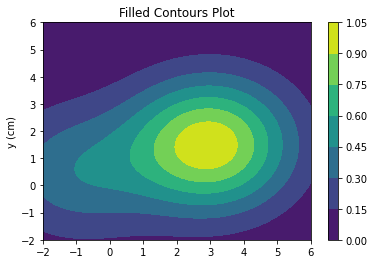

In [2969]:
xlist = np.linspace(-2,6, 100)
ylist = np.linspace(-2,6, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = makeGaussian((X,Y), 4, (0,0))
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()


In [2970]:
def rindex(lst, item):
    def index_ne(x):
        return lst[x] != item
    try:
        return next(dropwhile(index_ne, reversed(range(len(lst)))))
    except StopIteration:
        raise ValueError("rindex(lst, item): item not in list")  
        

In [2971]:
def addNewBeta(status, printOut = True):
    """ Add one move to expand the candidate list and pick the largest 8"""
    tempstatus = []
    for betaPre in status:  # betaPreviousTwoCandidates       
        distanceScore = []
        for nextHoldOrder in betaPre.holdsNotUsed:
            
            originalCom = betaPre.getCurrentCom() 
            dynamicThreshold = hyperparameter[0] * betaPre.lastMoveSuccessRateByHold()  
            finalXY = betaPre.getXYFromOrder(nextHoldOrder)
    
            distance = np.sqrt(((originalCom[0] - finalXY[0]) ** 2)+((originalCom[1] - finalXY[1]) ** 2))
            distanceScore.append(successRateByDistance(distance, dynamicThreshold))

        # Find the first and second smallest distance
        largestIndex = heapq.nlargest(min(8, len(distanceScore)), range(len(distanceScore)), key=distanceScore.__getitem__)
        
        #goodHoldIndex = [betaPre.holdsNotUsed[largestIndex[0]], betaPre.holdsNotUsed[largestIndex[1]], betaPre.holdsNotUsed[largestIndex[2]]]  #[#3,#5] holds
        goodHoldIndex = [betaPre.holdsNotUsed[i] for i in largestIndex]
        
        added = False
        for possibleHold in goodHoldIndex:
            for op in operationList:
                if betaPre.isFinished == False:
                   tempstatus.append(copy.deepcopy(betaPre))
                   tempstatus[-1].addNextHand(possibleHold, op)
                elif added == False:
                   tempstatus.append(copy.deepcopy(betaPre))
                   added = True
                   
    
    # trim tempstatus to pick the largest 3 
    finalScore = []       
    for i in tempstatus:
        finalScore.append(i.overallSuccessRate())    
    largestIndex = heapq.nlargest(8, range(len(finalScore)), key=finalScore.__getitem__) 
       
    if printOut == True:
        for i in largestIndex:
            print(tempstatus[i].handSequence, tempstatus[i].handOperator, tempstatus[i].overallSuccessRate()) 

    return [tempstatus[i] for i in largestIndex] 

Define Current Status

In [2972]:
testbeta = beta(moonboardTest.T)
status = [beta(moonboardTest.T), beta(moonboardTest.T)]
print("keyNum = ", keyNum)
print(status[0].allHolds)
moonboardTestUrl = MoonBoard_2016_withurl[keyNum]
print(moonboardTestUrl["url"])
# Initialized Start hold of two different beta
status[0].addStartHolds(0)
status[1].addStartHolds(1)

operationList = ["RH", "LH"]
tempstatus = []
tempstatus2 = []
tempstatus3 = []
distanceScore = []

keyNum =  310143
[[ 0.  2.  5.  2.  0.  0. 10.  4.  1.  0.]
 [ 0.  1.  3.  1.  0.  0. 10.  7.  0.  0.]
 [ 0.  1.  3.  1.  0.  0.  7.  8.  0.  0.]
 [ 0.  3.  3.  3.  0.  0. 10. 11.  0.  0.]
 [ 0.  5.  8.  5.  0.  0.  6. 12.  0.  0.]
 [ 1.  5.  2.  5.  1.  0.  8. 15.  0.  0.]
 [ 0.  2.  6.  9.  2.  0.  4. 17.  0.  1.]]
https://moonboard.com/Problems/View/310143/viva


In [2973]:
# Run the algorithm for 6 times
totalRun = status[0].totalNumOfHold - 1
for i in range(totalRun):  # how many new move you wan to add
    print (i)
    status = addNewBeta(status)
    finalScore = [] 
    for i in status:   
        finalScore.append(i.overallSuccessRate())
    largestIndex = heapq.nlargest(4, range(len(finalScore)), key=finalScore.__getitem__)
    if (status[largestIndex[0]].isFinished and status[largestIndex[1]].isFinished) == True:
        break

0
[0, 0, 2] ['LH', 'RH', 'LH'] 196.31317530788087
[0, 0, 2] ['LH', 'RH', 'LH'] 196.31317530788087
[0, 0, 1] ['LH', 'RH', 'RH'] 99.73227553433925
[0, 0, 1] ['LH', 'RH', 'LH'] 99.73227553433925
[0, 0, 1] ['LH', 'RH', 'RH'] 99.73227553433925
[0, 0, 1] ['LH', 'RH', 'LH'] 99.73227553433925
[0, 0, 2] ['LH', 'RH', 'RH'] 3.6079545081733024
[0, 0, 2] ['LH', 'RH', 'RH'] 3.6079545081733024
1
[0, 0, 2, 3] ['LH', 'RH', 'LH', 'RH'] 225.44082953750043
[0, 0, 2, 3] ['LH', 'RH', 'LH', 'RH'] 225.44082953750043
[0, 0, 1, 2] ['LH', 'RH', 'RH', 'LH'] 127.07351217853022
[0, 0, 1, 2] ['LH', 'RH', 'RH', 'LH'] 127.07351217853022
[0, 0, 2, 1] ['LH', 'RH', 'LH', 'RH'] 53.07071030142026
[0, 0, 2, 1] ['LH', 'RH', 'LH', 'RH'] 53.07071030142026
[0, 0, 1, 2] ['LH', 'RH', 'LH', 'LH'] 31.71044706703152
[0, 0, 1, 2] ['LH', 'RH', 'LH', 'LH'] 31.71044706703152
2
[0, 0, 2, 3, 4] ['LH', 'RH', 'LH', 'RH', 'LH'] 485.2248620366794
[0, 0, 2, 3, 4] ['LH', 'RH', 'LH', 'RH', 'LH'] 485.2248620366794
[0, 0, 1, 2, 3] ['LH', 'RH', 'RH

In [2974]:
# last sorting for the best 5
finalScore = [] 
print(status)
for i in status:   
    finalScore.append(i.overallSuccessRate())   
largestIndex = heapq.nlargest(4, range(len(finalScore)), key=finalScore.__getitem__)

[<__main__.beta object at 0x10f7bffa0>, <__main__.beta object at 0x15c91f730>, <__main__.beta object at 0x15c91f340>, <__main__.beta object at 0x15c181b80>, <__main__.beta object at 0x15c181bb0>, <__main__.beta object at 0x15c181190>, <__main__.beta object at 0x15c181070>, <__main__.beta object at 0x15c181220>]


In [2975]:
print(moonboardTestUrl["url"])
print ("After Beamer search, the most possible hand sequence and the successRate:")
for i in largestIndex:
    
    print(status[i].handSequence, status[i].handOperator, status[i].overallSuccessRate())    


https://moonboard.com/Problems/View/310143/viva
After Beamer search, the most possible hand sequence and the successRate:
[0, 0, 2, 3, 4, 5, 6] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH'] 561.7436103829656
[0, 0, 2, 3, 4, 5, 6] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH'] 561.7436103829656
[0, 0, 2, 3, 4, 5, 6] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH'] 561.7436103829656
[0, 0, 2, 3, 4, 5, 6] ['LH', 'RH', 'LH', 'RH', 'LH', 'RH', 'LH'] 561.7436103829656
